In [52]:
import pandas as pd
import pylab as plt
import torch
import numpy as np
import scipy as sp
import scipy.stats as st

In [2]:
df = pd.read_csv("./../data/APOB.txt", sep='\t', header=None)
del df[2]
del df[6]
df[8] = df[8].astype(int)
df.columns = ['SNP', 'CHROM', 'POS', 'A1', 'A2', 'ANN', 'AC', 'N']
df

,SNP,CHROM,POS,A1,A2,ANN,AC,N
0,2:21001734:A:G,2,21001734,G,A,missense|LC,1,343486
1,2:21001742:A:G,2,21001742,G,A,synonymous,1436,343486
2,2:21001743:G:A,2,21001743,A,G,missense|LC,3,343486
3,2:21001757:A:G,2,21001757,G,A,synonymous,1,343486
4,2:21001759:C:A,2,21001759,A,C,missense|LC,10,343486
...,...,...,...,...,...,...,...,...
2763,2:21043917:GC:G,2,21043917,G,GC,pLoF,405,343486
2764,2:21043928:G:T,2,21043928,T,G,synonymous,1,343486
2765,2:21043929:G:T,2,21043929,T,G,missense|LC,1,343486
2766,2:21043935:G:C,2,21043935,C,G,missense|LC,3,343486


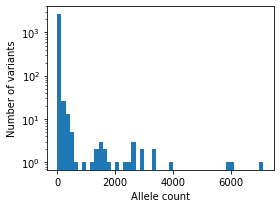

In [3]:
plt.figure(1, figsize=(4,3))
_ = plt.hist(df['AC'], 50)
plt.yscale('log')
plt.xlabel('Allele count')
plt.ylabel('Number of variants')
plt.tight_layout()

## Simulate X

In [132]:
def simulate_X(N, S, count):
    """
    Create a true 0/1 sparse tensor of dimensions N x S such that the sum of each column
    matches the corresponding count in the `count` array.

    Args:
    N (int): Number of rows.
    S (int): Number of columns.
    count (torch.Tensor): A 1D tensor of size S containing the count for each column.

    Returns:
    torch.Tensor: The resulting sparse tensor.
    """
    indices = []
    values = []

    for i in range(S):
        # Ensure the count does not exceed N
        num_ones = min(N, count[i])

        # Randomly choose positions to set to 1
        ones_positions = torch.randperm(N)[:num_ones]

        # Append the indices for the non-zero values
        for pos in ones_positions:
            indices.append([pos, i])
            values.append(1)

    # Convert lists to tensors
    indices_tensor = torch.tensor(indices).t().to(torch.int64)
    values_tensor = torch.tensor(values, dtype=torch.float)

    # Create a sparse tensor
    sparse_tensor = torch.sparse_coo_tensor(indices_tensor, values_tensor, (N, S))

    return sparse_tensor

In [133]:
# generate X
N = df['N'].values[0]
S = df.shape[0]
count = df['AC'].values
X = simulate_X(N, S, count)

## Annotation dataframe

In [102]:
dfannot = 1. * pd.get_dummies(df['ANN'])
dfannot['AF'] = df['AC'] / df['N']

## Allelic series simulation

In [103]:
def beta_pdf(maf, alpha):
    out = st.beta.pdf(maf, alpha, 1)
    return out / out.min()

In [122]:
def estimate_effect(dfannot, alpha=0.8):
    beta_eff = beta_pdf(dfannot['AF'].values, alpha)
    effects = dfannot['missense|LC'].values * beta_eff
    effects+= 1.5 * dfannot['pLoF'].values * beta_eff
    return effects

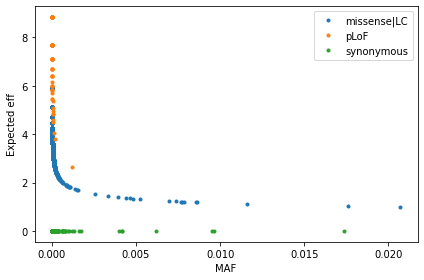

In [126]:
# Define effect
effects = estimate_effect(dfannot)
plt.plot(dfannot['AF'].values[dfannot['missense|LC']==1], effects[dfannot['missense|LC']==1], '.', color='C0', label='missense|LC')
plt.plot(dfannot['AF'].values[dfannot['pLoF']==1], effects[dfannot['pLoF']==1], '.', color='C1', label='pLoF')
plt.plot(dfannot['AF'].values[dfannot['synonymous']==1], effects[dfannot['synonymous']==1], '.', color='C2', label='synonymous')
plt.legend(loc=1)
plt.xlabel('MAF')
plt.ylabel('Expected eff')
plt.tight_layout()

In [144]:
genescore = X.mm(torch.Tensor(effects[:,None]))
y = torch.sigmoid(genescore - 6)

Text(0.5, 0, 'Aggregate linear score')

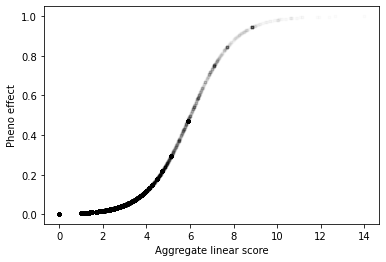

In [148]:
plt.plot(genescore.data.numpy().ravel(), y.data.numpy().ravel(), '.k', alpha=0.01)
plt.ylabel('Pheno effect')
plt.xlabel('Aggregate linear score')

In [31]:
# X = 343486 x 2767
# X.sum(0) <- match the real data

# burden score for pLoF
#Ikeep = df['ANN'].values=='pLoF'
#burden_pLof = X[:, Ikeep].max(1)
#y <-> burden_pLof